In [ ]:
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import L1L2


t = time.time()
df = pd.read_csv("final_dataset.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df_test = pd.read_csv("anomalous_dataset.csv")
print(time.time() - t)

44.49617409706116


In [ ]:
t = time.time()
train_data, test_data = train_test_split(df.values[:,:], test_size=0.2)


train_data = np.asarray(train_data).astype('float32')
test_data = np.asarray(test_data).astype('float32')
print(time.time() - t)

11.22422480583191


Epoch 1/10
5590/5590 [==============================] - 17s 3ms/step - loss: 0.0546 - val_loss: 0.0119
Epoch 2/10
5590/5590 [==============================] - 15s 3ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 3/10
5590/5590 [==============================] - 14s 3ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 4/10
5590/5590 [==============================] - 14s 3ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 5/10
5590/5590 [==============================] - 14s 3ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 6/10
5590/5590 [==============================] - 14s 3ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 7/10
5590/5590 [==============================] - 18s 3ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 8/10
5590/5590 [==============================] - 16s 3ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 9/10
5590/5590 [==============================] - 17s 3ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 10/10
5590/5590 [==============================] - 15s 3ms/step - l

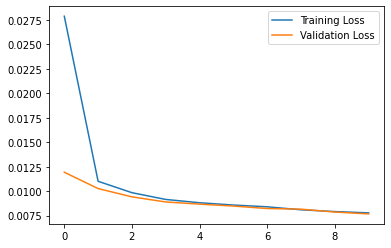

In [ ]:
from tensorflow.keras.regularizers import L1L2
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(92, activation="relu"),
      layers.Dense(46, activation="relu"),
      layers.Dense(30, activation="relu"),
      layers.Dense(20, activation="relu"),
      layers.Dense(8, activation="linear", activity_regularizer=L1L2(0.00001))])

    self.decoder = tf.keras.Sequential([
      layers.Dense(20, activation="relu"),
      layers.Dense(30, activation="relu"),
      #layers.Dense(86, activation="relu"),
      layers.Dense(46, activation="sigmoid")])
      
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss=["mae","accuracy"])
#autoencoder.summary()

history = autoencoder.fit(train_data, train_data,
          epochs=10,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
del df, train_data

In [ ]:
import tqdm
from sklearn.metrics import mean_absolute_error

test_ = np.asarray(df_test.values[:,:]).astype('float32')
predictions = []

for ind, sample in tqdm.tqdm(enumerate(test_)):
    sample = sample.reshape(-1,46)
    predictions.append(mean_absolute_error(sample, autoencoder.predict(sample)))

21429it [17:41, 20.18it/s]


Threshold 1 - mean from normal data.
Threshold 2 - mean from normal data times 3.
Threshold 3 - mean from normal data + std.
442 samples are misclassified feat. threshold #1.
7205 samples are misclassified feat. threshold #2.
2672 samples are misclassified feat. threshold #3.


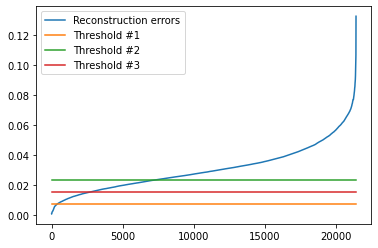

In [ ]:
plt.plot(sorted(predictions), label="Reconstruction errors")
plt.plot([1, len(predictions)], [0.0078, 0.0078], label="Threshold #1")
plt.plot([1, len(predictions)], [0.0078*3, 0.0078*3], label="Threshold #2")
plt.plot([1, len(predictions)], [mmean, mmean], label="Threshold #3")
plt.legend()

filtered_predictions_1 = [x for x in predictions if x < 0.0078]
filtered_predictions_2 = [x for x in predictions if x < 0.0078*3]
filtered_predictions_3 = [x for x in predictions if x < mmean]

print("Threshold 1 - mean from normal data.")
print("Threshold 2 - mean from normal data times 3.")
print("Threshold 3 - mean from normal data + std.")
print(f"{filtered_predictions_1.__len__()} samples are misclassified feat. threshold #1.")
print(f"{filtered_predictions_2.__len__()} samples are misclassified feat. threshold #2.")
print(f"{filtered_predictions_3.__len__()} samples are misclassified feat. threshold #3.")

In [ ]:
test_data = test_data[:10000]
predictions_norm = []

for ind, sample in tqdm.tqdm(enumerate(test_data)):
    sample = sample.reshape(-1,46)
    predictions_norm.append(mean_absolute_error(sample, autoencoder.predict(sample)))

10000it [06:36, 25.20it/s]


In [ ]:
mmean = sum(predictions_norm)/len(predictions_norm) + np.std(predictions_norm)